In [108]:
import numpy as np
import random
from PIL import Image
from matplotlib.pyplot import imshow
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt
from os import walk

%matplotlib inline

In [109]:
SEED = 342323425
np.random.seed(SEED)
MODE = 'RGB'
S = 3

In [110]:
IMG_PATH = './rsz_pic3.jpg'
def load_image(path):
    img = Image.open(path)
    return img.convert(MODE)

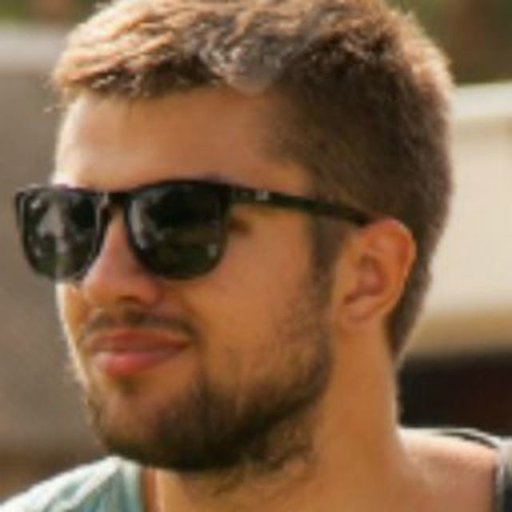

In [111]:
load_image(IMG_PATH)

In [112]:
def init_hyperparams(im):
    W, H = im.size
    n, m = 16, 16
    L = H / n * W / m
    N = n * m * S
    return W, H, n, m, L, N, S

pic = load_image(IMG_PATH)
W, H, n, m, L, N, S = init_hyperparams(pic)
print W, H, L, N, S
# imshow(pic)

512 512 1024 768 3


In [113]:
np.clip([1, 2, 3, 4, 5, 6, 7], 2, 5)

array([2, 2, 3, 4, 5, 5, 5])

In [114]:
def encode_pixel(P):
    C_MAX = 255.0
    P = np.array(P)
    return (2.0 * P / C_MAX) - 1.0

def encode_area(im, lu_corner, rb_corner):
    X0, Y0 = lu_corner
    X1, Y1 = rb_corner
    
    def transform(x, y):
        return encode_pixel(im.getpixel((x, y)))
    
    q = []
    for x in range(X0, X1 + 1):
        for y in range(Y0, Y1 + 1):
            q.append(transform(x, y))
    return np.array(q).flatten()

def decode_area(area):
    C_MAX = 255.0
    return np.clip(np.int_(C_MAX * (area + 1.0) / 2.0), 0, 255)

def decode_image(areas):
    if S == 1:
        im_area = np.empty((H, W))
    else:
        im_area = np.empty((H, W, S))
    for i in range(H):
        for j in range(W):
            ii = i / n
            jj = j / m
            idx = ii * (W / m) + jj
            im_area[j][i] = decode_area(areas[idx][0][(i % n) * m + j % m:(i % n) * m + j % m + S])
    return Image.fromarray(im_area.astype('uint8'), mode=MODE)

def transform_random_image(im, n, m):
    
    def transform(i, j):
        lu = (i, j)
        rb = (i + n - 1, j + m - 1)
        return encode_area(im, lu, rb)
    
    while True:
        i = np.random.randint(im.height - n)
        j = np.random.randint(im.width - m)
        X = transform(i, j)
        yield X.reshape(1, len(X))
        

def transform_image(im, n, m):
    
    def transform(i, j):
        lu = (i, j)
        rb = (i + n - 1, j + m - 1)
        return encode_area(im, lu, rb)
    
    for i in range(0, im.height, n):
        for j in range(0, im.width, m):
            X = transform(i, j)
            yield X.reshape(1, len(X))

In [115]:
def get_Z(N, L, p):
    return ((N + L) * p + 2.0) / (N * L)

In [116]:
# im = load_image(IMG_PATH)
# tr = transform_random_image(im, n, m)
# X = next(tr)
# print X.shape
# print X

In [146]:
def glorot_uniform(input_layers, output_layers):
    limit = np.sqrt(6.0 / (input_layers + output_layers))
    return partial(np.random.uniform, low=-limit, high=limit)

class Autoencoder(object):
    def __init__(self, input_layers=1000, lr=1e-2, max_err=1000.0, dynamic_lr=True, z=0.9, w_norm=True):
        self.input_layers = input_layers
        self.mid_layers = int(z * input_layers)
        self.initializer = glorot_uniform(self.input_layers, self.mid_layers)
        self.lr = lr
        self.w_norm = w_norm
        self.max_err = max_err
        self.dynamic_lr = dynamic_lr
        self.build()
        
    def error(self, err):
        return err**2
    
    def build(self):
        self.W1 = self.initializer(size=[self.input_layers, self.mid_layers])
        self.W2 = self.W1.T
    
    def __call__(self, im, n, m, pbar=None):
        gen = transform_image(im, n, m)
        err = 0.0
        for inp in gen:
            mid, res = self.forward(inp)
            diff = res - inp
            err += self.error(diff).sum()
            self.backward(inp, mid, diff)
            if pbar:
                pbar.update(1)
        return err
    
    def forward(self, inp):
        mid = self.encode(inp, self.W1)
        return mid, self.decode(mid, self.W2)
    
    def backward(self, inp, mid, err):
        lr = self.lr
        if self.dynamic_lr:
            lr = 1.0 / np.dot(inp, inp.T)**2
        self.W1 -= lr * np.dot(np.dot(inp.T, err), self.W2.T)
        if self.dynamic_lr:
            lr = 1.0 / np.dot(mid, mid.T)**2
        self.W2 -= lr * np.dot(mid.T, err)
        
        if self.w_norm:
            self.W2 /= np.linalg.norm(self.W2, axis=0, keepdims=True)
            self.W1 /= np.linalg.norm(self.W1, axis=1, keepdims=True)

    def encode(self, inp, W1):
        return np.dot(inp, W1)
    
    def decode(self, mid, W2):
        return np.dot(mid, W2)

In [186]:
def try_run(model, epochs, name='', th_err=0.1, viz=True, ax=None, path=IMG_PATH, progress=True):
    np.random.seed(SEED)
    errors = []
    im = load_image(path)
    best_results = {
        'W1': None,
        'W2': None,
        'min_err': 1e5,
        'epoch': epochs,
    }

    def run_iters(pbar=None):
        epoch_run = 0
        err = 1e10
        min_err = 1e10
        while epoch_run < epochs and err > th_err:
            errors.append(model(im, n, m, pbar))
            if errors[-1] < min_err:
                best_results['min_err'] = errors[-1]
                best_results['W1'] = model.W1
                best_results['W2'] = model.W2
                min_err = errors[-1]
            err = errors[-1]
            epoch_run += 1

        best_results['epoch'] = epoch_run

    if progress:
        with tqdm(total=epochs*L) as pbar:
            run_iters(pbar)
    else:
        run_iters()
    
    if viz:
        epoch = best_results['epoch']
        x = np.arange(epoch)
        idx = np.argmin(errors)
        print("BEST ERROR {} at {}".format(errors[idx], idx))
        
        if ax is None:
            plt.plot(x, np.array(errors))
            plt.title(name)
            plt.plot(x[idx], errors[idx], 'rx--', linewidth=2, markersize=12)
            plt.show()
        else:
            ax.plot(x, np.array(errors))
            ax.set_title(name)
            ax.plot(x[idx], errors[idx], 'rx--', linewidth=2, markersize=12)
    return best_results
    
def viz_encode(model, best_results, path=IMG_PATH):
    W1 = best_results['W1']
    W2 = best_results['W2']
    min_err = best_results['min_err']
    epoch = best_results['epoch']
    
    print 'Showing results for min_err={}. Epoch run: {}'.format(min_err, epoch)
    areas = []
    im = load_image(path)
    for area in transform_image(im, n, m):
        areas.append(model.decode(model.encode(area, W1), W2))
    areas = np.array(areas)
    new_pic = decode_image(areas)
    return new_pic

  0%|          | 15/51200 [00:00<05:49, 146.25it/s]

Running for z=0.1


100%|██████████| 51200/51200 [05:32<00:00, 153.91it/s]


BEST ERROR 5766.86406515 at 49
Showing results for min_err=5766.86406515. Epoch run: 50
(1024, 1, 768)


  0%|          | 7/51200 [00:00<13:29, 63.27it/s]

Running for z=0.366666666667


100%|██████████| 51200/51200 [11:17<00:00, 81.66it/s]


BEST ERROR 1374.18324324 at 49
Showing results for min_err=1374.18324324. Epoch run: 50
(1024, 1, 768)


  0%|          | 4/51200 [00:00<22:27, 37.99it/s]

Running for z=0.633333333333


100%|██████████| 51200/51200 [18:07<00:00, 47.09it/s]


BEST ERROR 718.8516077 at 49
Showing results for min_err=718.8516077. Epoch run: 50
(1024, 1, 768)


  0%|          | 3/51200 [00:00<28:30, 29.93it/s]

Running for z=0.9


100%|██████████| 51200/51200 [26:02<00:00, 32.68it/s]


BEST ERROR 488.79060025 at 49
Showing results for min_err=488.79060025. Epoch run: 50
(1024, 1, 768)


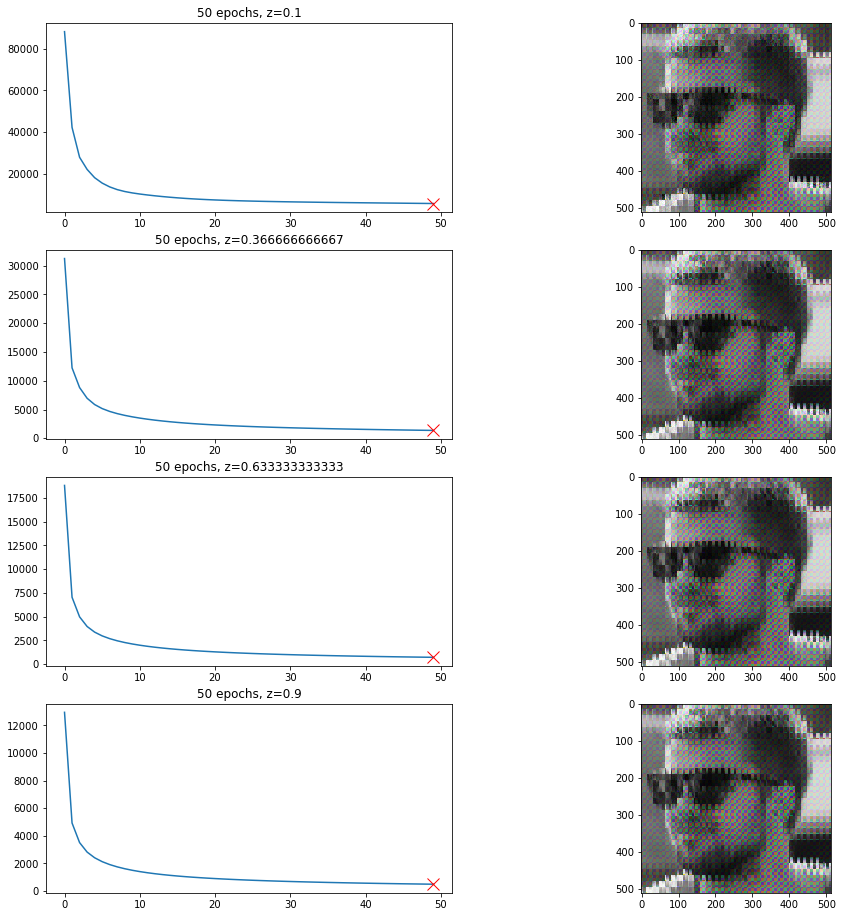

In [145]:
N_z = 4
fig, ax = plt.subplots(N_z, 2, figsize=(16, 16))
for i, z in enumerate(np.linspace(0.1, 0.9, N_z)):
    print 'Running for z={}'.format(z)
    epochs = 50
    model = Autoencoder(input_layers=N, z=z)
    best_results = try_run(model, epochs, '{} epochs, z={}'.format(epochs, z), th_err=100.0, ax=ax[i][0])
    new_pic = viz_encode(model, best_results)
    ax[i][1].imshow(new_pic)

100%|██████████| 51200/51200 [10:04<00:00, 91.13it/s]


BEST ERROR 873.948846041 at 49


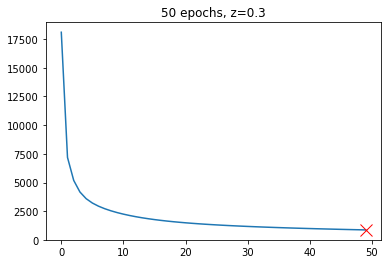

Showing results for min_err=873.948846041. Epoch run: 50
(1024, 1, 768)


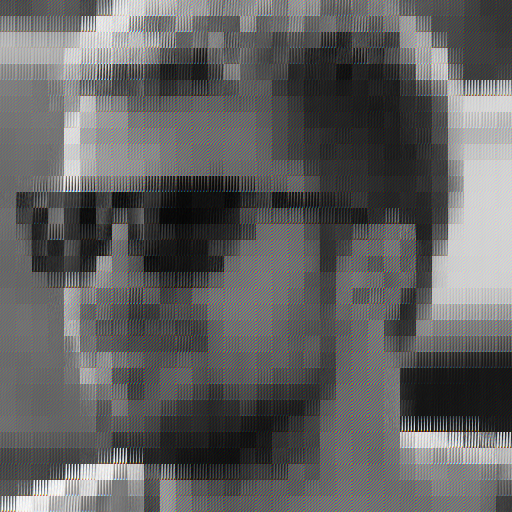

In [147]:
z = 0.3
epochs = 50
model = Autoencoder(input_layers=N, z=z, w_norm=False, dynamic_lr=True)
best_results = try_run(model, epochs, '{} epochs, z={}'.format(epochs, z), th_err=100.0, viz=True)
new_pic = viz_encode(model, best_results)
new_pic

100%|██████████| 51200/51200 [08:01<00:00, 111.94it/s]


BEST ERROR 3597.00682175 at 49


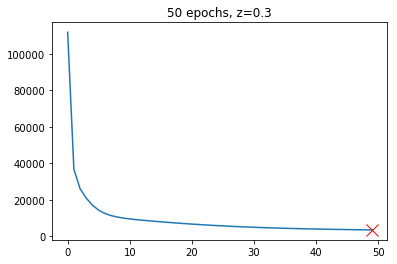

Showing results for min_err=3597.00682175. Epoch run: 50
(1024, 1, 768)


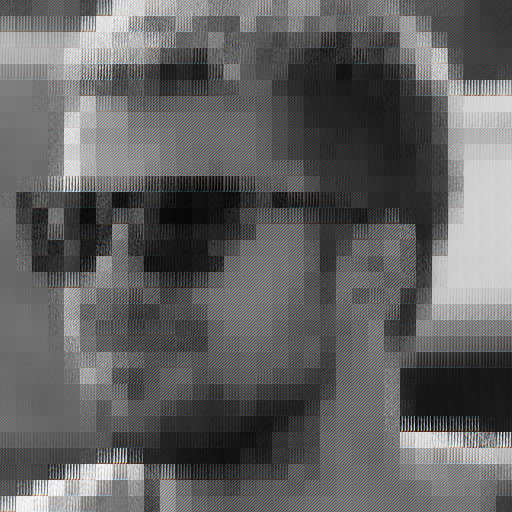

In [149]:
z = 0.3
epochs = 50
model = Autoencoder(input_layers=N, z=z, w_norm=False, dynamic_lr=False, lr=1e-5)
best_results = try_run(model, epochs, '{} epochs, z={}'.format(epochs, z), th_err=100.0, viz=True)
new_pic = viz_encode(model, best_results)
new_pic

100%|██████████| 51200/51200 [08:42<00:00, 97.93it/s] 


BEST ERROR 31533.8086971 at 49


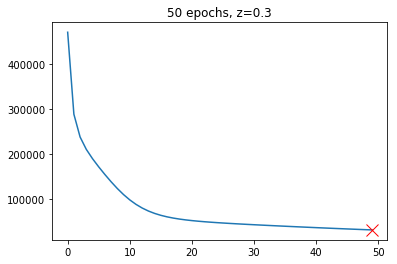

Showing results for min_err=31533.8086971. Epoch run: 50
(1024, 1, 768)


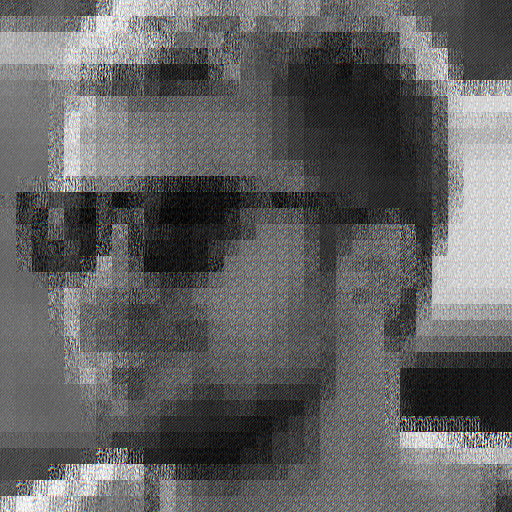

In [154]:
z = 0.3
epochs = 50
model = Autoencoder(input_layers=N, z=z, w_norm=True, dynamic_lr=False, lr=1e-6)
best_results = try_run(model, epochs, '{} epochs, z={}'.format(epochs, z), th_err=100.0, viz=True)
new_pic = viz_encode(model, best_results)
new_pic

  0%|          | 13/51200 [00:00<06:38, 128.61it/s]

Running for lr=1e-07


100%|██████████| 51200/51200 [05:54<00:00, 144.40it/s]


BEST ERROR 286534.178419 at 49
Showing results for min_err=286534.178419. Epoch run: 50
(1024, 1, 768)


  0%|          | 14/51200 [00:00<06:15, 136.18it/s]

Running for lr=2.575e-06


100%|██████████| 51200/51200 [05:28<00:00, 155.81it/s]


BEST ERROR 215280.474623 at 49
Showing results for min_err=215280.474623. Epoch run: 50
(1024, 1, 768)


  0%|          | 13/51200 [00:00<06:37, 128.71it/s]

Running for lr=5.05e-06


100%|██████████| 51200/51200 [05:33<00:00, 163.56it/s]


BEST ERROR 211165.189133 at 49
Showing results for min_err=211165.189133. Epoch run: 50
(1024, 1, 768)


  0%|          | 15/51200 [00:00<05:44, 148.62it/s]

Running for lr=7.525e-06


100%|██████████| 51200/51200 [05:37<00:00, 151.76it/s]


BEST ERROR 209363.048804 at 49
Showing results for min_err=209363.048804. Epoch run: 50
(1024, 1, 768)


  0%|          | 14/51200 [00:00<06:21, 134.12it/s]

Running for lr=1e-05


100%|██████████| 51200/51200 [05:18<00:00, 160.80it/s]


BEST ERROR 208325.881616 at 49
Showing results for min_err=208325.881616. Epoch run: 50
(1024, 1, 768)


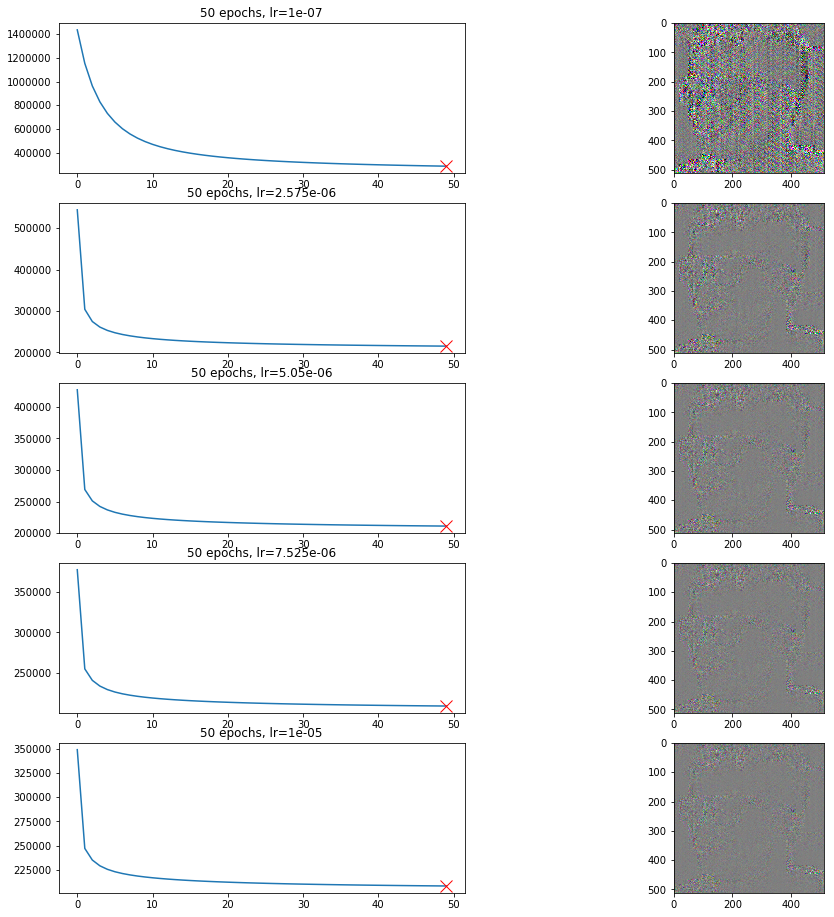

In [155]:
z = 0.15
lrs = np.linspace(1e-7, 1e-5, 5)
fig, ax = plt.subplots(lrs.shape[0], 2, figsize=(16, 16))
for i, lr in enumerate(lrs):
    print 'Running for lr={}'.format(lr)
    epochs = 50
    model = Autoencoder(input_layers=N, z=z, dynamic_lr=False, w_norm=True, lr=lr)
    best_results = try_run(model, epochs, '{} epochs, lr={}'.format(epochs, lr), th_err=100.0, ax=ax[i][0])
    new_pic = viz_encode(model, best_results)
    ax[i][1].imshow(new_pic)

100%|██████████| 20480/20480 [02:01<00:00, 168.45it/s]


BEST ERROR 129324.394857 at 19


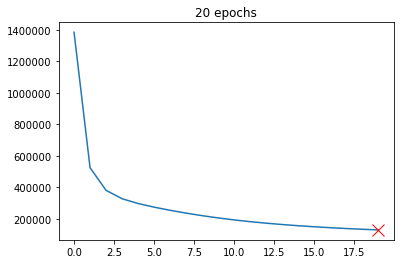

Showing results for min_err=129324.394857. Epoch run: 20


100%|██████████| 20480/20480 [02:10<00:00, 156.79it/s]


BEST ERROR 5795079428.37 at 0


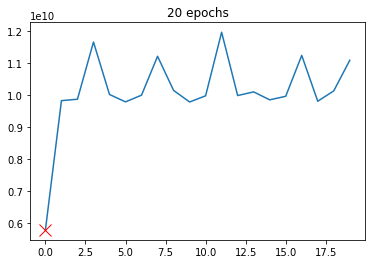

Showing results for min_err=5795079428.37. Epoch run: 20


100%|██████████| 20480/20480 [02:07<00:00, 160.21it/s]


BEST ERROR 426317.234185 at 19


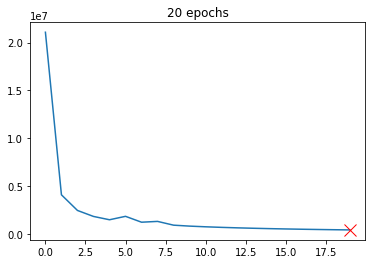

Showing results for min_err=426317.234185. Epoch run: 20


100%|██████████| 20480/20480 [02:03<00:00, 165.55it/s]


BEST ERROR 1786001.93728 at 19


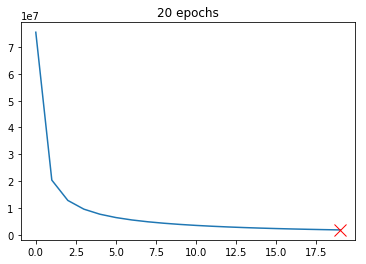

Showing results for min_err=1786001.93728. Epoch run: 20


100%|██████████| 20480/20480 [02:00<00:00, 170.45it/s]


BEST ERROR 3879521.77235 at 0


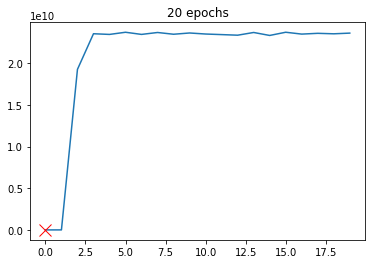

Showing results for min_err=3879521.77235. Epoch run: 20


 23%|██▎       | 4781/20480 [00:31<01:41, 154.18it/s]


KeyboardInterrupt: 

In [197]:
imgs = next(walk('./pics/'))[2]
epochs = 20
T = len(imgs)
# T = 2
model = Autoencoder(input_layers=N, z=0.1)
for i in range(T):
    path = './pics/{}'.format(imgs[i])
    best_results = try_run(model, epochs, '{} epochs'.format(epochs), th_err=15000.0, path=path, progress=True)
    new_pic = viz_encode(model, best_results, path=path)
#     fig, ax = plt.subplots(1, 2, figsize=(16, 9))
#     ax[0].imshow(load_image(path))
#     ax[1].imshow(new_pic)
#     fig.show()

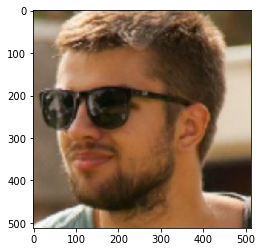

In [188]:
imshow(load_image(IMG_PATH))

In [43]:
def check(**kwargs):
    pic_path = kwargs.get('pic', IMG_PATH)
    pic = load_image(pic_path)
    init_params = ['W', 'H', 'n', 'm', 'L', 'N', 'S']
    default_params = {k: v for (k, v) in zip(init_params, init_hyperparams(pic))}
    params = {
        'epoch': 500,
        'th_err': 0.001,
        'p': 256,
        'dynamic_lr': True,
        'momentum': 0.95,
        'lr': 1e-5,
#         **default_params,
#         **kwargs,
    }
    params.update(default_params)
    params.update(kwargs)
    model = Autoencoder(input_layers=params['N'], mid_layers=params['p'], lr=params['lr'], dynamic_lr=params['dynamic_lr'])
    res = try_run(model, params['epoch'], '{} epochs, mid_layers={}'.format(params['epoch'], params['p']), th_err=params['th_err'], viz=False, momentum=params['momentum'])
    return res

Best:

100%|██████████| 550/550 [00:50<00:00, 10.88it/s]


Min 13 at 2.08830006917


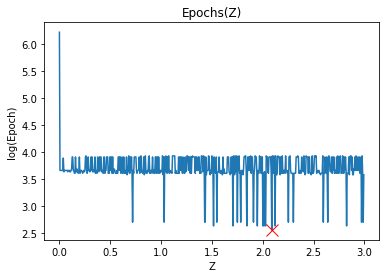

In [613]:
ps = np.arange(550)
epochs = []
for i in tqdm(range(len(ps))):
    epochs.append(check(p=ps[i], th_err=0.1)['epoch'])
idx = np.argmin(epochs)
x = map(partial(get_Z, N, L), ps)
y = np.log(epochs)
print 'Min {} at {}'.format(epochs[idx], x[idx])
plt.plot(x, y)
plt.title('Epochs(Z)')
plt.xlabel('Z')
plt.ylabel('log(Epoch)')
plt.plot(x[idx], y[idx], 'rx--', linewidth=2, markersize=12)
plt.show()

100%|██████████| 100/100 [00:53<00:00,  1.85it/s]


Min 51 at 0.097


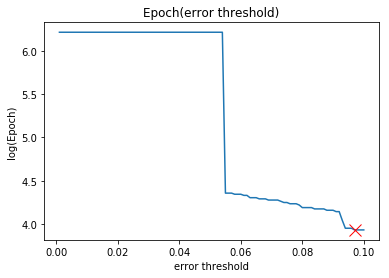

In [625]:
es = np.linspace(0.001, 0.1, 100)
epochs = []
for i in tqdm(range(len(es))):
    epochs.append(check(th_err=es[i])['epoch'])
idx = np.argmin(epochs)
x = es
y = np.log(epochs)
print 'Min {} at {}'.format(epochs[idx], x[idx])
plt.plot(x, y)
plt.title('Epoch(error threshold)')
plt.xlabel('error threshold')
plt.ylabel('log(Epoch)')
plt.plot(x[idx], y[idx], 'rx--', linewidth=2, markersize=12)
plt.show()

100%|██████████| 200/200 [00:24<00:00,  8.20it/s]


Min 35 at 0.00855185929648


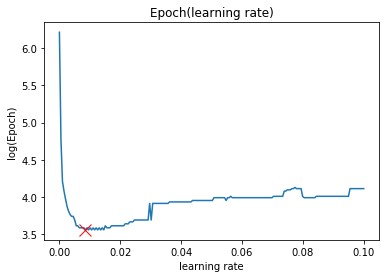

In [627]:
lr = np.linspace(0.00001, 0.1, 200)
epochs = []
for i in tqdm(range(len(lr))):
    epochs.append(check(lr=lr[i], th_err=0.1, dynamic_lr=False)['epoch'])
idx = np.argmin(epochs)
x = lr
y = np.log(epochs)
print 'Min {} at {}'.format(epochs[idx], x[idx])
plt.plot(x, y)
plt.title('Epoch(learning rate)')
plt.xlabel('learning rate')
plt.ylabel('log(Epoch)')
plt.plot(x[idx], y[idx], 'rx--', linewidth=2, markersize=12)
plt.show()

100%|██████████| 15/15 [00:06<00:00,  2.28it/s]

Min 327 at 1


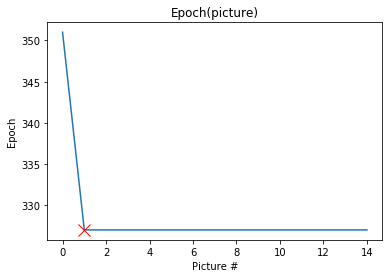

In [58]:
imgs = next(walk('./pics/'))[2]
epochs = []
for i in tqdm(range(len(imgs))):
    epochs.append(check(pic='./pics/{}'.format(imgs[i]), p=128, th_err=0.15, lr=0.001)['epoch'])
idx = np.argmin(epochs)
x = np.arange(len(imgs))
y = epochs
print 'Min {} at {}'.format(epochs[idx], x[idx])
plt.plot(x, y)
plt.title('Epoch(picture)')
plt.xlabel('Picture #')
plt.ylabel('Epoch')
plt.plot(x[idx], y[idx], 'rx--', linewidth=2, markersize=12)
plt.show()

100%|██████████| 100/100 [00:42<00:00,  2.37it/s]

Min 74 at 0.00545501708984


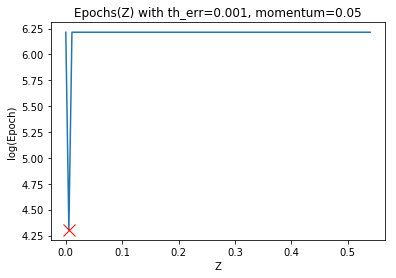

100%|██████████| 100/100 [00:02<00:00, 44.68it/s]


Min 2 at 0.00545501708984


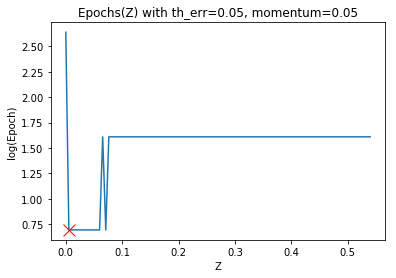

100%|██████████| 100/100 [00:02<00:00, 49.56it/s]


Min 2 at 2.54313151042e-06


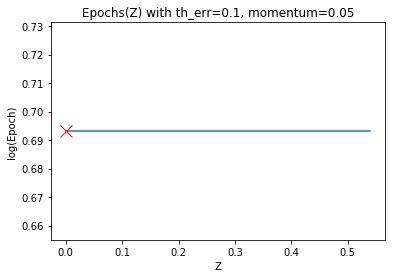

100%|██████████| 100/100 [00:43<00:00,  2.29it/s]

Min 500 at 2.54313151042e-06


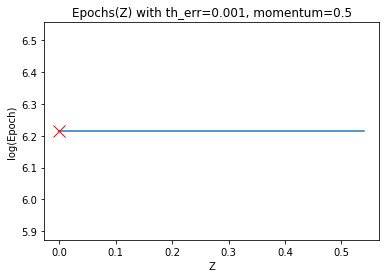

100%|██████████| 100/100 [00:02<00:00, 36.47it/s]


Min 7 at 0.0381698608398


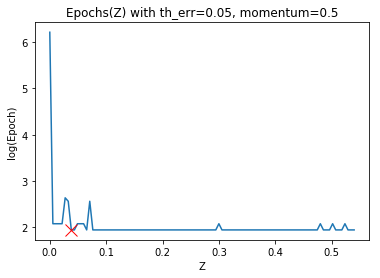

100%|██████████| 100/100 [00:02<00:00, 48.48it/s]


Min 2 at 0.00545501708984


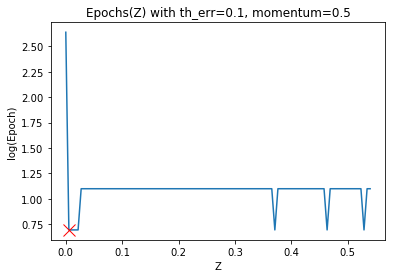

100%|██████████| 100/100 [00:45<00:00,  2.18it/s]

Min 500 at 2.54313151042e-06


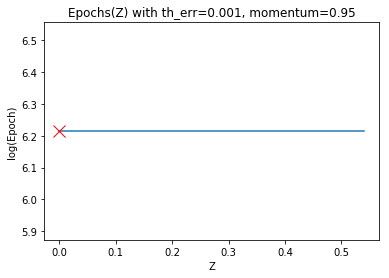

100%|██████████| 100/100 [00:09<00:00, 10.48it/s]

Min 81 at 0.0381698608398


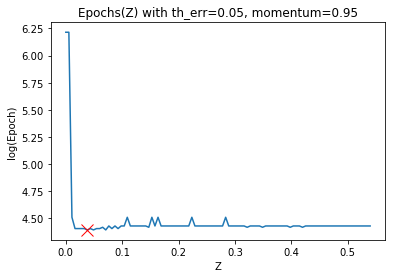

100%|██████████| 100/100 [00:06<00:00, 15.61it/s]


Min 15 at 0.485272725423


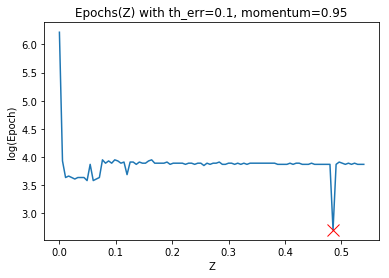

In [58]:
ms = np.array([0.05, 0.5, 0.95])
th_errs = np.array([0.001, 0.05, 0.1])
for mm in ms:
    for th_err in th_errs:
        ps = np.arange(100)
        epochs = []
        for i in tqdm(range(len(ps))):
            epochs.append(check(p=ps[i], th_err=th_err, momentum=mm)['epoch'])
        idx = np.argmin(epochs)
        x = map(partial(get_Z, N, L), ps)
        y = np.log(epochs)
        print 'Min {} at {}'.format(epochs[idx], x[idx])
        plt.plot(x, y)
        plt.title('Epochs(Z) with th_err={}, momentum={}'.format(th_err, mm))
        plt.xlabel('Z')
        plt.ylabel('log(Epoch)')
        plt.plot(x[idx], y[idx], 'rx--', linewidth=2, markersize=12)
        plt.show()

In [9]:
next(walk('./pics/'))[2]

['images (2).jpeg',
 'download.jpeg',
 'images (4).jpeg',
 'download.png',
 'images.jpeg',
 'Icon_Pinguin_1_512x512.png',
 'images (6).jpeg',
 'images (1).jpeg',
 '20130726104253-512X512.png',
 'images (3).jpeg',
 'images (5).jpeg',
 'w512h5121390847141chrome512.png',
 'anger-512x512.png',
 'Icon_Bird_512x512.png',
 '512x512-png-images-5.png',
 'oDJcJC3.png']

(512, 512)


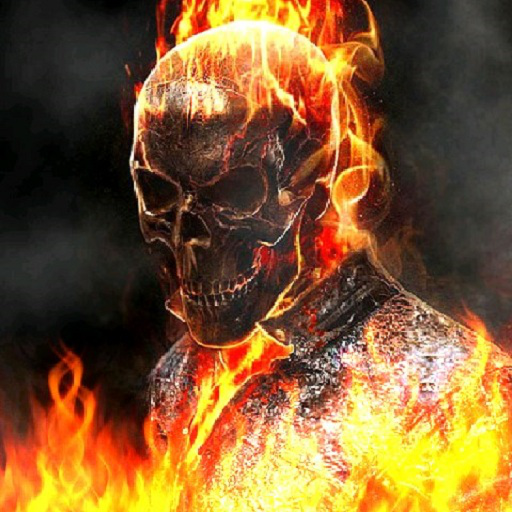

In [50]:
im = load_image(IMG_PATH)
print im.size
im

In [ ]:
3) glorot function from?